In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm  # 可视化进度条，pip install tqdm

# 1. Download Data
symbol = "^GSPC,^VIX,VXX"
start_date = "1970-01-01"
end_date = "2025-05-02"

data = yf.download(symbol, start=start_date, end=end_date)
close_prices = data.xs('Close', level='Price', axis=1)
data = pd.DataFrame(close_prices)
data['log_ret'] = np.log(data['^GSPC']).diff()
data = data.dropna(subset=['log_ret'])
print(data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed

Ticker            VXX        ^GSPC       ^VIX   log_ret
Date                                                   
1970-01-05        NaN    93.459999        NaN  0.004934
1970-01-06        NaN    92.820000        NaN -0.006871
1970-01-07        NaN    92.629997        NaN -0.002049
1970-01-08        NaN    92.680000        NaN  0.000540
1970-01-09        NaN    92.400002        NaN -0.003026
...               ...          ...        ...       ...
2025-04-25  63.340000  5525.209961  24.840000  0.007346
2025-04-28  63.680000  5528.750000  25.150000  0.000641
2025-04-29  63.020000  5560.830078  24.170000  0.005786
2025-04-30  64.639999  5569.060059  24.700001  0.001479
2025-05-01  63.419998  5604.140137  24.600000  0.006279

[13952 rows x 4 columns]


In [2]:
# 2. GARCH Modeling: 每天fit一次，只用历史数据
returns = data['log_ret'] * 100
garch_vol = np.full(len(returns), np.nan)
min_garch_window = 252  # 至少一年数据，防止收敛失败

print("Fitting GARCH for each sample point (no leakage, this may take a while)...")
for t in tqdm(range(min_garch_window, len(returns))):
    ret_hist = returns.values[:t+1]  # 只到当前点
    try:
        garch = arch_model(ret_hist, vol='GARCH', p=1, q=1)
        garch_fit = garch.fit(disp='off')
        garch_vol[t] = garch_fit.conditional_volatility[-1]
    except Exception as e:
        # 万一fit失败，设为NaN（可选）
        garch_vol[t] = np.nan

data['garch_vol'] = garch_vol

Fitting GARCH for each sample point (no leakage, this may take a while)...


100%|████████████████████████████████████████████████████████████████████████████| 13700/13700 [16:05<00:00, 14.19it/s]


C:\Users\yeguofeng\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
384/384 - 21s - 54ms/step - loss: 0.2962 - val_loss: 0.1528
Epoch 2/30
384/384 - 10s - 27ms/step - loss: 0.0950 - val_loss: 0.0583
Epoch 3/30
384/384 - 20s - 52ms/step - loss: 0.0382 - val_loss: 0.0240
Epoch 4/30
384/384 - 11s - 28ms/step - loss: 0.0152 - val_loss: 0.0109
Epoch 5/30
384/384 - 19s - 51ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 6/30
384/384 - 10s - 26ms/step - loss: 0.0031 - val_loss: 0.0077
Epoch 7/30
384/384 - 10s - 26ms/step - loss: 0.0018 - val_loss: 0.0083
Epoch 8/30
384/384 - 10s - 26ms/step - loss: 0.0014 - val_loss: 0.0099
Epoch 9/30
384/384 - 13s - 33ms/step - loss: 0.0013 - val_loss: 0.0083
Epoch 10/30
384/384 - 11s - 29ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 11/30
384/384 - 10s - 26ms/step - loss: 0.0011 - val_loss: 0.0117
Epoch 12/30
384/384 - 10s - 26ms/step - loss: 0.0012 - val_loss: 0.0085
Epoch 13/30
384/384 - 10s - 25ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 14/30
384/384 - 10s - 26ms/step - loss: 0.0011 - val_loss: 0.0043
E

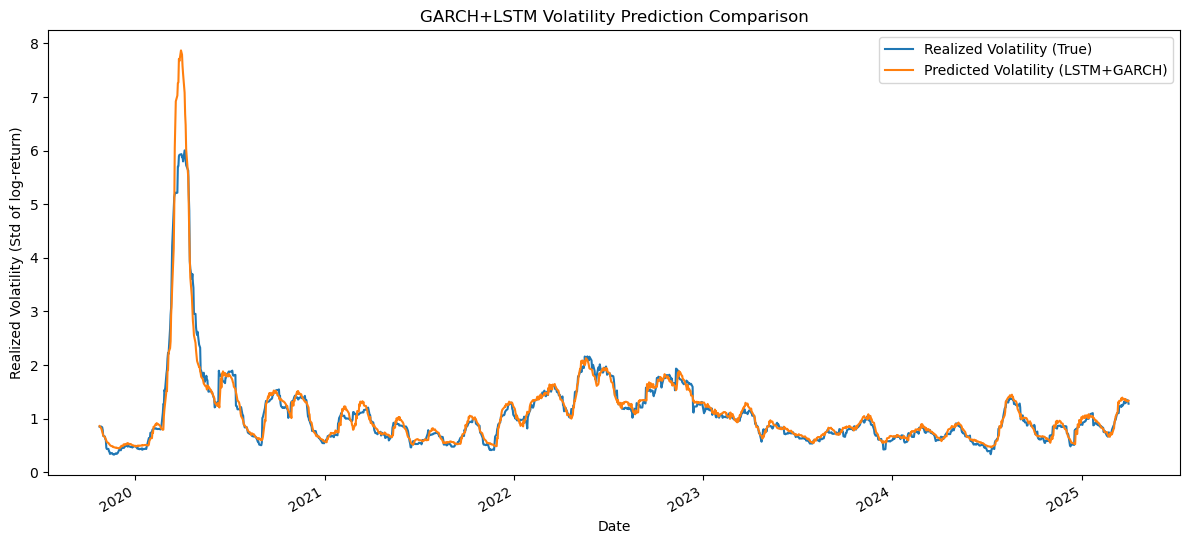

In [53]:
# 3. Realized Volatility (未来22-day rolling std)
window = 22
data['realized_vol'] = returns.rolling(window).std()
# .shift(-window+1)
data = data.dropna(subset=['realized_vol','garch_vol'])

# 4. Create LSTM Features and Labels
lookback = 30
features = []
labels = []
dates = []

for i in range(lookback, len(data)):
    feat = np.hstack([
        returns.values[i-lookback:i],
        data['garch_vol'].values[i-lookback:i]
    ])
    label = data['realized_vol'].values[i]
    features.append(feat)
    labels.append(label)
    dates.append(data.index[i])
features = np.array(features)
labels = np.array(labels)
dates = np.array(dates)

# 划分
no_features = 2
split = int(0.9 * len(features))
features_train, features_test = features[:split], features[split:]
labels_train, labels_test = labels[:split], labels[split:]

# 只用训练集fit
# from sklearn.preprocessing import StandardScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(features_train)
X_test_scaled = scaler_x.transform(features_test)
y_train_scaled = scaler_y.fit_transform(labels_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(labels_test.reshape(-1, 1))

# reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], lookback, no_features))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], lookback, no_features))

X_train, X_test = X_train_lstm, X_test_lstm
y_train, y_test = y_train_scaled, y_test_scaled
dates_train, dates_test = dates[:split], dates[split:]

# 7. Build LSTM Model
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(lookback, 2)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, y_test), verbose=2)

# 8. Prediction & Evaluation
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"LSTM-GARCH Hybrid Model RMSE: {rmse:.6f}  MAE: {mae:.6f}")

# 9. Visualization
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test_inv, label='Realized Volatility (True)')
plt.plot(dates_test, y_pred_inv, label='Predicted Volatility (LSTM+GARCH)')
plt.title(f'GARCH+LSTM Volatility Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Realized Volatility (Std of log-return)')
plt.legend()
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

Ticker            VXX        ^GSPC       ^VIX   log_ret  garch_vol  \
Date                                                                 
1990-01-02        NaN   359.690002  17.240000  0.017642   0.746012   
1990-01-03        NaN   358.760010  18.190001 -0.002589   0.858564   
1990-01-04        NaN   355.670013  19.219999 -0.008650   0.833321   
1990-01-05        NaN   352.200012  20.110001 -0.009804   0.841558   
1990-01-08        NaN   353.790009  20.260000  0.004504   0.858297   
...               ...          ...        ...       ...        ...   
2025-03-26  46.939999  5712.200195  18.330000 -0.011220   1.151579   
2025-03-27  47.180000  5693.310059  18.690001 -0.003312   1.152415   
2025-03-28  51.419998  5580.939941  21.650000 -0.019935   1.104377   
2025-03-31  51.470001  5611.850098  22.280001  0.005523   1.218510   
2025-04-01  51.480000  5633.069824  21.770000  0.003774   1.169912   

Ticker      realized_vol  garch_vol_scaled  
Date                                        

C:\Users\yeguofeng\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/118 - 16s - 138ms/step - loss: 0.5918 - val_loss: 1.1638 - learning_rate: 0.0010
Epoch 2/100
118/118 - 5s - 44ms/step - loss: 0.3841 - val_loss: 0.8285 - learning_rate: 0.0010
Epoch 3/100
118/118 - 5s - 42ms/step - loss: 0.3106 - val_loss: 0.5207 - learning_rate: 0.0010
Epoch 4/100
118/118 - 5s - 43ms/step - loss: 0.2610 - val_loss: 0.3192 - learning_rate: 0.0010
Epoch 5/100
118/118 - 5s - 42ms/step - loss: 0.2273 - val_loss: 0.2296 - learning_rate: 0.0010
Epoch 6/100
118/118 - 5s - 43ms/step - loss: 0.1937 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 7/100
118/118 - 6s - 48ms/step - loss: 0.1759 - val_loss: 0.1783 - learning_rate: 0.0010
Epoch 8/100
118/118 - 6s - 48ms/step - loss: 0.1564 - val_loss: 0.1621 - learning_rate: 0.0010
Epoch 9/100
118/118 - 9s - 74ms/step - loss: 0.1403 - val_loss: 0.1525 - learning_rate: 0.0010
Epoch 10/100
118/118 - 4s - 35ms/step - loss: 0.1331 - val_loss: 0.1454 - learning_rate: 0.0010
Epoch 11/100
118/118 - 5s - 38ms/step - loss: 0.1157 - val_

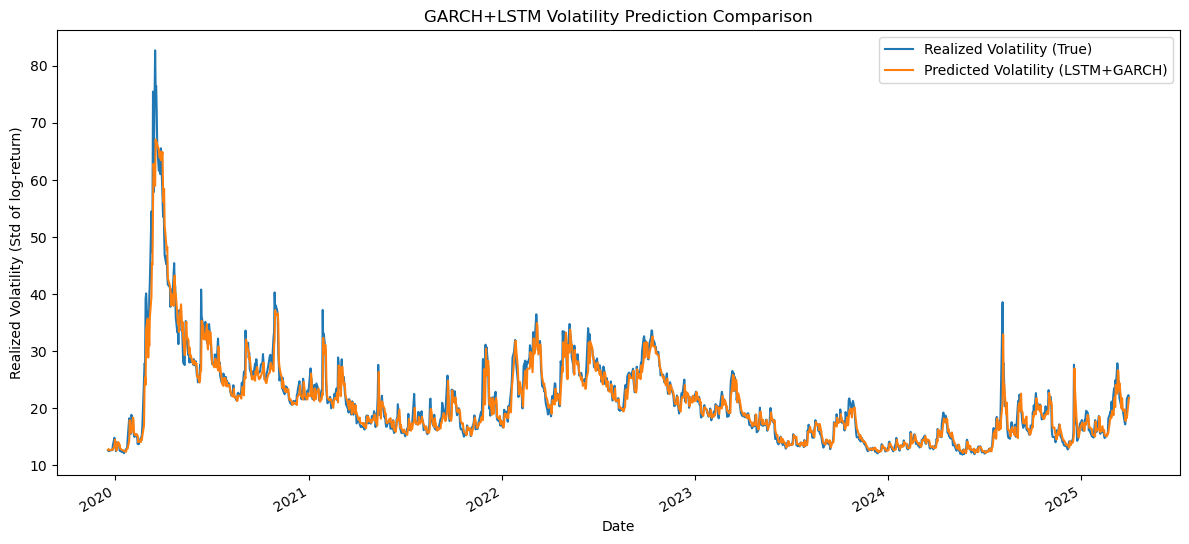

In [245]:
# 3. Realized Volatility (VIX)

from sklearn.preprocessing import StandardScaler
print(data)

lookback = 30
data['realized_vol'] = data['^VIX']

data = data.dropna(subset=['^VIX'])

print(data)

# 4. Create LSTM Features and Labels

features = []
labels = []
dates = []

for i in range(lookback, len(data)):
    feat = np.hstack([
        returns.values[i-lookback:i],
        data['garch_vol'].values[i-lookback:i],
        data['^VIX'].values[i-lookback:i]
    ])
    label = data['realized_vol'].values[i]
    features.append(feat)
    labels.append(label)
    dates.append(data.index[i])
features = np.array(features)
labels = np.array(labels)
dates = np.array(dates)

no_features=3

# 划分
split = int(0.85 * len(features))
features_train, features_test = features[:split], features[split:]
labels_train, labels_test = labels[:split], labels[split:]

# 只用训练集fit
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_x.fit_transform(features_train)
X_test_scaled = scaler_x.transform(features_test)
y_train_scaled = scaler_y.fit_transform(labels_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(labels_test.reshape(-1, 1))

# reshape for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], lookback, no_features))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], lookback, no_features))

X_train, X_test = X_train_lstm, X_test_lstm
y_train, y_test = y_train_scaled, y_test_scaled
dates_train, dates_test = dates[:split], dates[split:]

# # 5. Normalization
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()
# X_scaled = scaler_x.fit_transform(features)
# y_scaled = scaler_y.fit_transform(labels.reshape(-1, 1))
# X_lstm = X_scaled.reshape((X_scaled.shape[0], lookback, 3))

# # 6. Train/Test Split
# split = int(0.85* len(X_lstm))
# X_train, X_test = X_lstm[:split], X_lstm[split:]
# y_train, y_test = y_scaled[:split], y_scaled[split:]
# dates_train, dates_test = dates[:split], dates[split:]

# 7. Build LSTM Model
tf.random.set_seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(lookback, 3)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(1)
])

# model = Sequential([
#     LSTM(64, input_shape=(lookback, no_features), return_sequences=False),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dense(1)
# ])

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  # 默认0.001，可自行设置
model.compile(optimizer=optimizer, loss='mse')

from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(step_decay)

history = model.fit(
    X_train, y_train, epochs=100, batch_size=64,
    validation_data=(X_test, y_test), verbose=2,
    callbacks=[lr_scheduler]
)

# 8. Prediction & Evaluation
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
print(y_pred, y_pred_inv)
y_test_inv = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"LSTM-GARCH Hybrid Model RMSE: {rmse:.6f}  MAE: {mae:.6f}")

# 9. Visualization
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test_inv, label='Realized Volatility (True)')
plt.plot(dates_test, y_pred_inv, label='Predicted Volatility (LSTM+GARCH)')
plt.title(f'GARCH+LSTM Volatility Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Realized Volatility (Std of log-return)')
plt.legend()
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

In [4]:
# print(data[['garch_vol', 'realized_vol']])

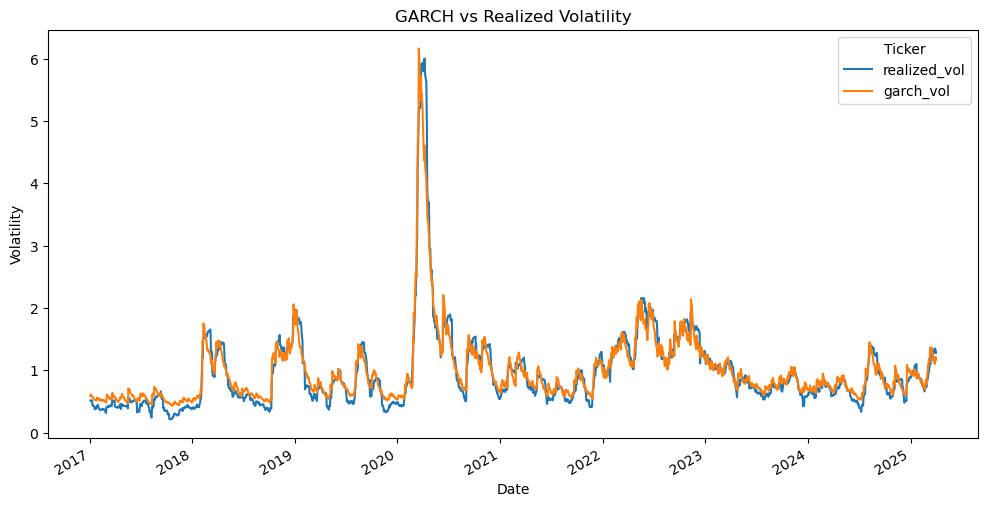

In [57]:
subset = data['2017-01-01':'2025-05-02']
subset[['realized_vol','garch_vol']].plot(figsize=(12, 6), title='GARCH vs Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

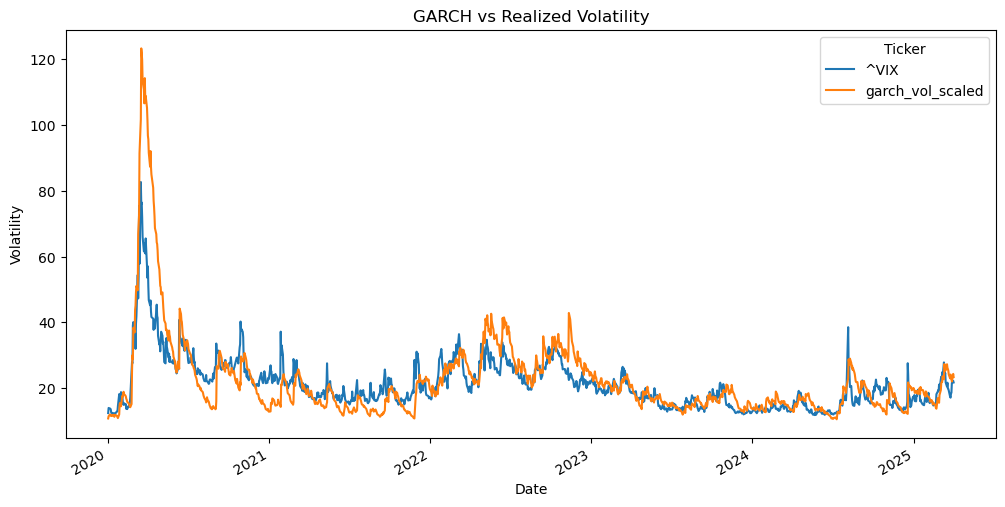

In [59]:
data['garch_vol_scaled'] = data['garch_vol']*20
subset = data['2020-01-01':'2025-05-02']
subset[['^VIX','garch_vol_scaled']].plot(figsize=(12, 6), title='GARCH vs Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()